---
---
*<h1 align='center'> Violence Detection in Videos </h1>*

***<h2 align='center'> Progress - 4 </h2>***

---
---
Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>
DATASETS: 
- Real Life Violence Situations Dataset: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset </br>
size: 2GB, 1000-Violence / 1000-NonViolence
- Hockey Fight Detection Dataset: https://academictorrents.com/details/38d9ed996a5a75a039b84cf8a137be794e7cee89 </br>
size: 212MB, 500-Violence / 500-NonViolence
- Movies Fight Detection Dataset: https://academictorrents.com/details/70e0794e2292fc051a13f05ea6f5b6c16f3d3635 </br>
size: 734MB, 100-Violence / 100-NonViolence
- Violent-Flows - Crowd Violence \ Non-violence Database: http://www.cslab.openu.ac.il/download/violentflow/ </br>
size: 240MB, 146-Violence / 125-NonViolence (links to yt videos are no longer valid in csv files)

### **Importing required packages**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
#matplotlib.rcParams.update({'text.color' : "blue"})
from IPython.display import HTML

import os
from tqdm import tqdm # to get progress bars while running
import cv2
from sklearn.utils import shuffle

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.disable_eager_execution()
tf.debugging.set_log_device_placement(True)
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)))

import warnings
warnings.filterwarnings('ignore')

### **Load Premilinary Funtions**

In [5]:
# all pre-processing funtions Returns Video converted to list of frames of shape (height, width, channels)

def ReadVideo(dim,filename,framerate):
    cap = cv2.VideoCapture(filename)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_multiplier = total_frames/framerate
    
    # Read Video Frames according to req-frames:file-frames ratio
    frame_counter = 0
    while(cap.isOpened()):
        status,frame = cap.read()
        if(status):
            if(frame_counter%frame_multiplier <= 1):
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # so we are converting to RGB format
                
                # cropping out black border areas
                gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                _,thresh = cv2.threshold(gray,5,255,cv2.THRESH_BINARY) # threshold => 255 > pixel_value > 5 
                contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                
                max_dim = 100 # finding the max bounds, keep threshold 100 min req pixels
                for k in contours:
                    _,_,tw,th = cv2.boundingRect(k)
                    if tw*th > max_dim :
                        max_dim = tw*th
                        x,y,w,h = cv2.boundingRect(k)
                if max_dim == 100:
                    continue # means complete black screen, skip this frame
                crop = image[y:y+h,x:x+w]
                # resizing
                img = cv2.resize(crop, (dim[0], dim[1])) 
                # normalization done in model
                
                frames.append(img)
            frame_counter = frame_counter + 1;
        else:
            cap.release() # closing video file if not more fromes present
    # returns list of frames (atmost frame-rate)
    return frames


def ExtractMotion(frames): # need to return a copy, not modify in frame itself
    blobs =[]
    for i in range(1,len(frames)):
        blobs.append(np.absolute(frames[i] - frames[i-1])) # abs diff bet 2 consecutive frames
    return blobs


def ResizeFrames(frames, outframes):
    frame_counter = len(frames)
    nt = 1
    while(frame_counter!=outframes):
        middle = frame_counter//2
        if(outframes-frame_counter < 0):
            # removing frames
            if((frame_counter-outframes)%2==0):
                if(frame_counter-1-2*nt < 0):
                    nt = nt//2
                frames.pop(frame_counter-1-2*nt)
                frames.pop(2*nt)
            else:
                frames.pop(middle)
        else:
            # add padding of slow-motion effect like
            # repeating frames in middle
            if((frame_counter-outframes)%2==0):
                if(middle+2*nt > frame_counter-1):
                    nt = nt//2
                frames.insert(middle-2*nt,frames[middle-2*nt])
                frames.insert(middle+2*nt+1,frames[middle+2*nt+1])
            else:
                frames.insert(middle,frames[middle])
        nt = nt+1
        frame_counter = len(frames)
    return frames

In [6]:
# User-defined load data function to read our data folders and label each of the videos with 
# names of class-folder in sequential order
def Load_Data_classwise(root_dir, *class_folders, need_motions=True):
    '''To import the dataset from the directories and preprocess them'''
        
    # final outputs:
    videos=[]
    motions=[]
    labels=[]
    
    # iterate through folders in each dataset
    for folder in os.listdir(root_dir):
        if(folder in class_folders):
            
            label = class_folders.index(folder)
            
            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(root_dir, folder))):
                
                # get pathname of each image
                vid_path = os.path.join(os.path.join(root_dir, folder), file)
               
                # Open, rescale, pre-process(motion features), re
                try:
                    video = ReadVideo(frame_size,vid_path, max_frame_rate)
                except:
                    video = ReadVideo(frame_size,vid_path, output_frames+1)
                if (need_motions == True):
                    motion = ExtractMotion(video) # motion blobs --> abs diff bet 2 consecutive frames
                    motion = ResizeFrames(motion, output_frames)
                
                video = ResizeFrames(video, output_frames)
                # Normalization is done in Model to avoid memory wasted 
                # by numpy as it turns data to float from int8
                    
                # Append the image and its corresponding label to the output
                videos.append(video)
                if (need_motions == True):
                    motions.append(motion)
                labels.append(label)
                
            print(root_dir+"... Loading-Class", label, "-->", folder, "over.")
                
    # Converting the data type of the list
    if (need_motions == True):
        return np.array(videos), np.array(motions), np.array(labels, dtype = 'int8')
    else:
        return np.array(videos), np.array(labels, dtype = 'int8')

In [7]:
# User-defined load data function to read our data folders and label each of the videos with 
# names of file_prefixes in sequential order
def Load_Data_prefixwise(folder_dirs, *file_prefixes, need_motions=True):
    '''To import the dataset from the directories and preprocess them'''
    
    # final outputs:
    videos=[]
    motions=[]
    labels=[]
    
    # iterate through folders
    for folder_dir in folder_dirs:
        
        # iterate through each image in folder
        for file in tqdm(os.listdir(folder_dir)):  
            
            for i in range(len(file_prefixes)):
                if (file.startswith(file_prefixes[i])):
                    
                    # get pathname of each image
                    vid_path = os.path.join(folder_dir, file) 
                    
                    # Open, rescale, pre-process(motion features), re
                    try:
                        video = ReadVideo(frame_size,vid_path, max_frame_rate)
                    except:
                        video = ReadVideo(frame_size,vid_path, output_frames+1)
                    if (need_motions == True):
                        motion = ExtractMotion(video) # motion blobs --> abs diff bet 2 consecutive frames
                        motion = ResizeFrames(motion, output_frames)
                    
                    video = ResizeFrames(video, output_frames)
                    # Normalization is done in Model to avoid memory wasted 
                    # by numpy as it turns data to float from int8
                    
                    # Append the image and its corresponding label to the output
                    videos.append(video)
                    if (need_motions == True):
                        motions.append(motion)
                    labels.append(i)
                
        print(folder_dir+"... Loading-Class with Prefixes", np.arange(len(file_prefixes)), "-->", file_prefixes, "over.")
                
    # Converting the data type of the list
    if (need_motions == True):
        return np.array(videos), np.array(motions), np.array(labels, dtype = 'int8')
    else:
        return np.array(videos), np.array(labels, dtype = 'int8')

In [8]:
def Combine_All(*VideosLabels):
    combine = []
    for x in range(len(VideosLabels[0])):
        combine.append(np.concatenate(tuple(i[x] for i in VideosLabels),axis=0))
    return tuple(combine)

### **Data Loading and Pre-Processing**

In [9]:
class_names = ["Violence","NonViolence"]
frame_size = (112,112,3) # 112x112 for C3D
#max_frame_rate = 32 # max no.of frames taken while reading in one video 
output_frames = 16 # assumption that 16 consecutive frames are enough for this data to fit into C3D

In [10]:
# Loading Data - Train-Test videos
# if running in kaggle use: Load(kaggle_dir+"folder_dir",**class_folders)
#kaggle_dir = '/kaggle/input/violence-detection-in-videos'
videos, optical_flows, labels = Combine_All(Load_Data_classwise('Data/Real Life Violence Dataset', 'Violence', 'NonViolence'),
                                            Load_Data_prefixwise(['Data/HockeyFights'], 'fi', 'no'),
                                            Load_Data_classwise('Data/Peliculas', 'fights', 'noFights'),
                                            Load_Data_classwise('Data/ViolentFlows/movies/1', 'Violence', 'NonViolence'),
                                            Load_Data_classwise('Data/ViolentFlows/movies/2', 'Violence', 'NonViolence'),
                                            Load_Data_classwise('Data/ViolentFlows/movies/3', 'Violence', 'NonViolence'),
                                            Load_Data_classwise('Data/ViolentFlows/movies/4', 'Violence', 'NonViolence'),
                                            Load_Data_classwise('Data/ViolentFlows/movies/5', 'Violence', 'NonViolence'),
                                            Load_Data_classwise('Data/ViolentFlows/21VideosForDetection', 'ForTal'))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.52it/s]


Data/Real Life Violence Dataset... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]


Data/Real Life Violence Dataset... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.66it/s]


Data/HockeyFights... Loading-Class with Prefixes [0 1] --> ('fi', 'no') over.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.43it/s]


Data/Peliculas... Loading-Class 0 --> fights over.


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:05<00:00, 16.95it/s]


Data/Peliculas... Loading-Class 1 --> noFights over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.95it/s]


Data/ViolentFlows/movies/1... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.32it/s]


Data/ViolentFlows/movies/1... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 53.32it/s]


Data/ViolentFlows/movies/2... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.26it/s]


Data/ViolentFlows/movies/2... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.90it/s]


Data/ViolentFlows/movies/3... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.99it/s]


Data/ViolentFlows/movies/3... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 49.81it/s]


Data/ViolentFlows/movies/4... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 48.82it/s]


Data/ViolentFlows/movies/4... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 49.73it/s]


Data/ViolentFlows/movies/5... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 47.72it/s]


Data/ViolentFlows/movies/5... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 16.18it/s]


Data/ViolentFlows/21VideosForDetection... Loading-Class 0 --> ForTal over.


In [8]:
print(f'Shape of Videos Data : {videos.shape}')
print(f'Shape of Optical-Flow Data : {optical_flows.shape}')

Shape of Videos Data : (3468, 16, 112, 112, 3)
Shape of Optical-Flow Data : (3468, 16, 112, 112, 3)


### **Data Visualization**

Data: Labels and their count :
 Counter({0: 1744, 1: 1724})


Text(0, 0.5, 'Count')

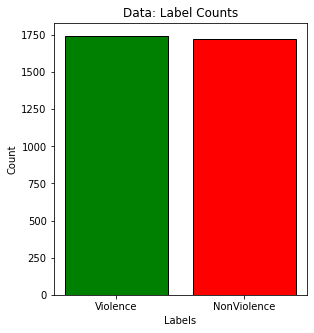

In [9]:
from collections import Counter
fig = plt.figure(figsize = (10,5))


label_count = Counter(labels)
print(f'Data: Labels and their count :\n {label_count}')
x = list(label_count.keys())
y = list(label_count.values())

plt.subplot(1,2,1)
plt.bar(x,y,color=['red','green'],  edgecolor='black')
plt.title('Data: Label Counts')
plt.xticks([0,1],class_names)
plt.xlabel('Labels')
plt.ylabel('Count')

In [10]:
def dis_rand_exp(videos, motions, labels, x=2, y=6):
    
    fig = plt.figure(figsize = (20,15))
    fig.suptitle("Rand-Exps of dataset Videos --> Optical Flows", fontsize=32)
    ax = []
    rand = []
    vp = []
    mp = []
    for i in range(0,2*x*y,2):
        # create a figure and axes
        ax.append(plt.subplot(2*x,y,i+1))
        ax.append(plt.subplot(2*x,y,i+2))
        
        # create objects that will change in the animation. These are
        # initially empty, and will be given new values for each frame
        # in the animation.
        rand.append(random.randint(0,len(labels)))
        vp.append(ax[i].imshow(videos[rand[-1]][0,:,:,:], cmap='gray'))
        mp.append(ax[i+1].imshow(motions[rand[-1]][0,:,:,:], cmap='gray'))
        ax[i].set_title(class_names[labels[rand[-1]]], fontsize=18)
        ax[i+1].set_title("Optical Flow", fontsize=18)
    
    # set axes
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.axis('off')
    fig.subplots_adjust(left=0, bottom=0.1, right=0.1, top=0.2, wspace=0, hspace=0.5)
    fig.tight_layout()
    plt.close()
    
    # defining animation function
    def animate(i):
        for j in range(0,x*y):
            vp[j].set_data(videos[rand[j]][i,:,:,:])
            mp[j].set_data(motions[rand[j]][i,:,:,:])
        return vp,mp
    
    anim = animation.FuncAnimation(fig, animate, frames=output_frames, interval=60)
    return anim

In [ ]:
HTML(dis_rand_exp(videos, optical_flows, labels).to_jshtml())
# Output not shown, as it makes the file size too big, 
# its few frames of video in playback input representation after resp data preprocessing

---
*<h1 align='center'> Transfer Learning Models </h1>*

---

## C3D Model Feature Extracting
Description: C3D Model for Keras trained over Sports 1M</br>
Author: Alberto Montes</br>

Advisors: Xavier Giro and Amaia Salvador</br>

We provide an adaptation to Keras of the C3D model used with a fork of Caffe, which was trained over the Sports1M dataset.</br>

Details about the network architecture can be found in the following paper:</br>

Tran, Du, Lubomir Bourdev, Rob Fergus, Lorenzo Torresani, and Manohar Paluri. "Learning Spatiotemporal Features With 3D Convolutional Networks." In Proceedings of the IEEE International Conference on Computer Vision, pp. 4489-4497. 2015.</br>

Find our model and an example of how to use on this page on Github Gist.</br>

For more info: https://medium.com/@nair.binum/quick-overview-of-convolutional-3d-features-for-action-and-activity-recognition-c3d-138f96d58d8f </br>

Model link: https://gist.githubusercontent.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2/raw/1e2620258ce619e18d3219cf962a3f0a0ed17093/sports_1M.json </br>
 Weights link: https://drive.google.com/file/d/0BzmDUR5_3US0V1hjV3VvREJ3NGs/view?resourcekey=0-3EPDTvM5_Eaa1_tyH87LAg </br>
 
 Updated Keras version weights link: https://drive.google.com/file/d/1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm/view

### Features extraction
To extract features from a video you should:</br>

Divide a video into 16 frame chunks with 8 frame overlaps (dim=(16, 112, 112, 3)).</br>
Use output from the first fully connected layer **`fc6`** as a features from the single chunk. (implemented in sport1m_model.create_features_exctractor)
Average features extracted from all vectors to form a single vector (dim=4096).</br>
L2-normalize the vector.</br>

In [2]:
try: # .json gives error
    C3D_model = keras.models.model_from_json(open('sports_1M.json', 'r').read())
except: # recreating the same model architechture
    
    C3D_model = keras.models.Sequential([
        # 1st layer group
        keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape = (16, 112, 112, 3)),
        keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'),
        
        # 2nd layer group
        keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'),
        
        # 3rd layer group
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'),
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'),
        
        # 4th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'),
        
        # 5th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'),
        keras.layers.ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'),
        
        keras.layers.Flatten(),
        
        # FC layers group
        keras.layers.Dense(4096, activation='relu', name='fc6'),
        keras.layers.Dropout(.5, name='drop1'),
        keras.layers.Dense(4096, activation='relu', name='fc7'),
        keras.layers.Dropout(.5, name='drop2'),
        keras.layers.Dense(487, activation='softmax', name='fc8')
    ])


In [3]:
try:
    C3D_model.load_weights('sports1M_weights.h5')
except:
    C3D_model.load_weights('C3D_Sport1M_weights_keras_2.2.4.h5')
#C3D_model.compile(loss='mean_squared_error', optimizer='sgd')
C3D_model._name="C3D"
C3D_model.summary()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5

Model: "C3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None,

In [25]:
C3D_customized = keras.models.Sequential([
    
    ## input of conv1-pool1-conv2-pool2
    keras.Input(shape=C3D_model.get_layer('pool2').output_shape[1:],name='c1p1c2p2'),
    
    ## conv-block-3
    C3D_model.get_layer('conv3a'),
    C3D_model.get_layer('conv3b'),
    keras.layers.ConvLSTM2D(256, (3, 3), return_sequences=True, activation='relu', padding='same', name='conv3-ltsm'),
    C3D_model.get_layer('pool3'),
    
    ## conv-block-4
    C3D_model.get_layer('conv4a'),
    C3D_model.get_layer('conv4b'),
    keras.layers.ConvLSTM2D(512, (3, 3), return_sequences=True, activation='relu', padding='same', name='conv4-ltsm'),
    C3D_model.get_layer('pool4'),
    
    ## conv-block-5
    C3D_model.get_layer('conv5a'),
    C3D_model.get_layer('conv5b'),
    keras.layers.ConvLSTM2D(512, (3, 3), return_sequences=True, activation='relu', padding='valid', name='conv5-ltsm'),
    #keras.layers.ZeroPadding3D(padding=((1, 1), (0, 1), (0, 1)), name='zeropad5'),
    #C3D_model.get_layer('pool5'),
    keras.layers.BatchNormalization(name='Bat-Norm'),
    
    keras.layers.TimeDistributed(keras.layers.Flatten(), name='TD-flatten'),
    
    ## Singlar LTSM instead of Dense
    keras.layers.LSTM(4096, activation='relu', name='ltsm6'),
    keras.layers.Dropout(.5, name='drop1'),
    
    ## FC layers group
    C3D_model.get_layer('fc7'),
    keras.layers.Dropout(.5, name='drop2'),
    
    ## Output
    keras.layers.Dense(1, 'sigmoid')
    #keras.layers.Dense(2, activation='softmax', name='fc8')
])

C3D_customized.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])
#C3D_customized.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
C3D_customized._name="C3D_customized"
C3D_customized.summary()

Model: "C3D_customized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
conv3-ltsm (ConvLSTM2D)      (None, 8, 28, 28, 256)    4719616   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
_________________________________________________________________
conv4a (Conv3D)              (None, 4, 14, 14, 512)    3539456   
_________________________________________________________________
conv4b (Conv3D)              (None, 4, 14, 14, 512)    7078400   
_________________________________________________________________
conv4-ltsm (ConvLSTM2D)      (None, 4, 14, 14, 512) 

In [ ]:
tf.keras.backend.clear_session
C3D_c1p1c2p2 = keras.models.Sequential([
    ## preprocessing - Normalization
    keras.layers.Normalization(input_shape=(16, 112, 112, 3)),
    
    ## conv-block-1
    keras.Model(inputs = C3D_model.inputs, outputs = C3D_model.get_layer('pool2').output, name='C3D_c1p1c2p2'),
])
C3D_c1p1c2p2._name="C3D_c1p1c2p2"
c1p1c2p2 = C3D_c1p1c2p2.predict(videos,batch_size=4)

In [26]:
c1p1c2p2.shape

(3468, 8, 28, 28, 128)

In [ ]:
#Stop training when a monitored metric (here, accuracy) has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

# Saving the best Trained model
model_file = C3D_customized.name+'_Video_Model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

tf.keras.backend.clear_session
history = C3D_customized.fit(c1p1c2p2,
                    labels,
                    epochs=15, # Max no.of epochs
                    batch_size=1, # size for parallel computation, higher require more GPU/CPU-RAM
                    validation_split=0.15,
                    shuffle=True, # Shuffling the order of data for better accuracy and a good data split
                    callbacks=[early_stopping_cb, checkpoint_cb]
                   )

## **Feature Extraction**

In [12]:
print("\n\nPrinting layers of Model -",C3D_model.name,":")
for layer in C3D_model.layers:
    print(layer.name,'-->',layer)

print("\nFeature extraction from the model:")
feature_layer = C3D_model.get_layer('fc6')
print(feature_layer)



Printing layers of Model - C3D :
conv1 --> <keras.layers.convolutional.Conv3D object at 0x0000023F8811B6A0>
pool1 --> <keras.layers.pooling.MaxPooling3D object at 0x0000023F8F0C4190>
conv2 --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0A6E50>
pool2 --> <keras.layers.pooling.MaxPooling3D object at 0x0000023F8F0C4790>
conv3a --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0C4490>
conv3b --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0C4A90>
pool3 --> <keras.layers.pooling.MaxPooling3D object at 0x0000023F8F0F9220>
conv4a --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0C4EE0>
conv4b --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0F9520>
pool4 --> <keras.layers.pooling.MaxPooling3D object at 0x0000023F8F0F9C70>
conv5a --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0F9970>
conv5b --> <keras.layers.convolutional.Conv3D object at 0x0000023F8F0F9F70>
zeropad5 --> <keras.layers.convolutional.ZeroPadding3D obje

C3D Model Architecture


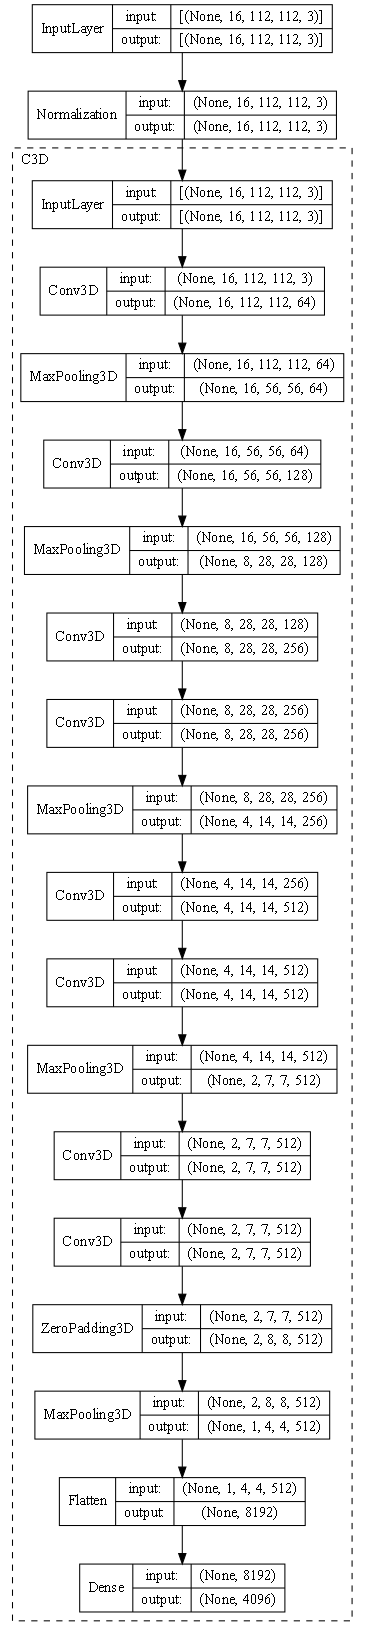

In [18]:
feature_model = keras.models.Sequential([
    ## preprocessing - Normalization
    keras.layers.Normalization(input_shape=(16, 112, 112, 3)),
    ## Feature Extractor
    keras.Model(inputs = C3D_model.inputs, outputs = feature_layer.output, name='C3D'),
])
feature_model._name="C3D_Feature_Extractor"

# Showing C3D Model Architecture
print("C3D Model Architecture")
keras.utils.plot_model(feature_model,'C3D.png',show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=75)
# rankdir='TB' -> top to bottom
#feature_model.summary()

### **Extracting the deep features directly from Videos of our Dataset**

In [19]:
import time
tf.keras.backend.clear_session
start_time = time.time(); video_features = feature_model.predict(videos,batch_size=20); feat_time = time.time() - start_time;
print("Time time taken to extract features from complete Video Data -->:", feat_time, "(s)")


Time time taken to extract features from complete Video Data -->: 90.70519256591797 (s)


### **Extracting the deep features from Optical-Flow of our Dataset**

In [20]:
import time
tf.keras.backend.clear_session
start_time = time.time(); optical_features = feature_model.predict(optical_flows,batch_size=20); feat_time = time.time() - start_time;
print("Time time taken to extract features from complete Optical Flow Data -->:", feat_time, "(s)")

Time time taken to extract features from complete Optical Flow Data -->: 85.01873755455017 (s)


In [21]:
#Saving C3D Features Datasets
np.savez_compressed('C3D_features',video_features,optical_features, labels)

---
*<h1 align='center'> ML Classifiers </h1>*

---

In [3]:
video_features,optical_features,labels = np.load('C3D_features.npz')

with np.load('C3D_features.npz') as data:
    video_features = data[video_features]
    optical_features = data[optical_features]
    labels = data[labels]

In [4]:
def get_features_statistics(Vf):
    # Check video feature values
    Vdf = pd.DataFrame(Vf)
    Vi_min = Vdf.min().min()
    Vi_max = Vdf.max().max()
    Vi_mean = Vdf.stack().mean()
    Vi_stdev = Vdf.stack().std()
    print(f' Features:\
    shape = {Vf.shape}, \
    min = {Vi_min:.3f}, \
    max = {Vi_max:.3f}, \
    mean = {Vi_mean:.3f}, \
    deviation = {Vi_stdev:.3f}')  

In [5]:
print('Video -',end=''); get_features_statistics(video_features)
print('Optical -',end=''); get_features_statistics(optical_features)

Video - Features:    shape = (3468, 4096),     min = 0.000,     max = 35.824,     mean = 0.593,     deviation = 1.624
Optical - Features:    shape = (3468, 4096),     min = 0.000,     max = 35.824,     mean = 0.593,     deviation = 1.624


In [6]:
features = np.hstack((video_features, optical_features))
print(f'Shape of complete set of Features : {features.shape}')
print(f'Shape of Labels : {labels.shape}')

Shape of complete set of Features : (3468, 8192)
Shape of Labels : (3468,)


### *Feature Scaling*

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print('StandardScaler -',end=''); get_features_statistics(features_scaled)

scaler = MinMaxScaler()
features_minmax = scaler.fit_transform(features)
print('MinMaxScaler -',end=''); get_features_statistics(features_minmax)

StandardScaler - Features:    shape = (3468, 8192),     min = -3.222,     max = 58.881,     mean = 0.000,     deviation = 0.995
MinMaxScaler - Features:    shape = (3468, 8192),     min = 0.000,     max = 1.000,     mean = 0.055,     deviation = 0.131


In [8]:
feat_df = pd.DataFrame(features)
feat_df['label'] = labels
feat_df.shape

(3468, 8193)

In [12]:
corr = feat_df.corr()

In [13]:
corr

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,label
0,1.000000,0.036611,0.083998,0.063217,0.035328,-0.063448,0.025121,-0.031026,-0.053942,-0.040665,...,-0.011256,-0.129273,-0.016784,-0.016604,0.032979,-0.029101,-0.004271,-0.008598,-0.158162,0.085014
1,0.036611,1.000000,-0.002025,0.012909,-0.018258,-0.046773,0.003644,0.260425,-0.057641,-0.016488,...,0.070693,-0.023730,-0.017687,-0.016911,0.045132,-0.006453,0.063120,-0.013278,0.010143,-0.069750
2,0.083998,-0.002025,1.000000,0.114185,0.223444,0.004873,0.104420,0.125404,-0.100490,-0.055590,...,0.078945,-0.139111,0.009863,-0.012973,-0.052064,-0.033504,0.016715,0.024862,-0.173592,0.195085
3,0.063217,0.012909,0.114185,1.000000,0.103224,-0.056167,0.050351,0.150716,-0.067018,0.003265,...,-0.017329,0.013816,0.017234,-0.011624,0.018898,0.029084,-0.009592,-0.016943,0.014781,0.067647
4,0.035328,-0.018258,0.223444,0.103224,1.000000,-0.050972,-0.068557,0.006300,-0.012762,0.046769,...,-0.011609,-0.133773,-0.008362,0.029598,-0.018695,-0.004242,0.036788,0.025185,-0.106258,0.110585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188,-0.029101,-0.006453,-0.033504,0.029084,-0.004242,-0.052281,0.023630,-0.007167,-0.028064,-0.053606,...,0.006556,0.125586,0.173532,0.019493,-0.003749,1.000000,-0.004515,0.003554,0.246908,-0.021749
8189,-0.004271,0.063120,0.016715,-0.009592,0.036788,-0.002358,-0.014212,0.004343,-0.009522,-0.004405,...,0.004627,-0.044262,0.024851,-0.009605,-0.006424,-0.004515,1.000000,0.029997,-0.011346,0.029266
8190,-0.008598,-0.013278,0.024862,-0.016943,0.025185,-0.006722,-0.018678,-0.009527,0.003199,0.027203,...,-0.006373,0.018057,-0.002230,0.003955,0.012408,0.003554,0.029997,1.000000,0.016877,0.025024
8191,-0.158162,0.010143,-0.173592,0.014781,-0.106258,-0.038646,0.054238,-0.024304,0.023397,0.063903,...,-0.076229,0.299772,0.019454,0.030304,-0.008146,0.246908,-0.011346,0.016877,1.000000,-0.280146


In [14]:
feature_selection = list(corr['label'].loc[(corr.label>0.05)].index)[0:-1]

In [15]:
temp_feat_df = feat_df[feature_selection]
temp_feat_scaled_df = pd.DataFrame(features_scaled)[feature_selection]
temp_feat_minmax_df = pd.DataFrame(features_minmax)[feature_selection]

In [16]:
temp_feat_df.shape

(3468, 2754)

### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

names = ["Linear SVM", "Poly SVM", "RBF SVM", "Sig SVM", "lbfgs Log-Reg", 
         "saga Log-Reg", "SGD", "Naive Bayes","KMeans", "Gaussian Process", 
         "Decision Tree", "Random Forest", "KNN", "Neural Net", "AdaBoost", 
         "GradientBoost", "QDA", "LGBM", "XGB", "CatBoost"]

classifiers = [SVC(kernel='linear',max_iter=5000), SVC(kernel='poly',max_iter=5000), 
               SVC(kernel='rbf',max_iter=5000), SVC(kernel='sigmoid',max_iter=5000),
               LogisticRegression(solver='lbfgs'), LogisticRegression(solver='saga'), SGDClassifier(), 
               GaussianNB(), KMeans(n_clusters=len(class_names)), GaussianProcessClassifier(), 
               DecisionTreeClassifier(max_depth=10), RandomForestClassifier(max_depth=10), KNeighborsClassifier(), 
               MLPClassifier(max_iter=1000,early_stopping=True), AdaBoostClassifier(), 
               GradientBoostingClassifier(max_depth=10), QuadraticDiscriminantAnalysis(),
               LGBMClassifier(), XGBClassifier(), CatBoostClassifier(iterations=100,learning_rate=0.1,silent=True)]

#### *Fitting and Ploting results*

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

def runML():
    for i in range(len(class_names)):
        print("CLASS -",i,"-->",class_names[i])

    fig = plt.figure(figsize=(18,14))
    fig.tight_layout()
    nof_clsfrs = len(names)
    Metrics = {}
    
    print('\nClassification Report for each Classifier:')
    for i in range(nof_clsfrs):
        metric = []
        classifier = classifiers[i]
        plt.subplot(nof_clsfrs/5,5,i+1)
        plt.xticks([])
        plt.yticks([])
    
        print(f'\n\nClassifier: {str(classifier)[0:25]}...')
        if 'KMeans' in str(classifier):
            # for KMeans, we use the entire features data as it unsupervised
            start_time = time.time(); classifier.fit(features, labels); metric.append(time.time() - start_time);
            metric.append(metric[-1]) # test run time is same
        else:
            start_time = time.time(); classifier.fit(train_features, train_labels); metric.append(time.time() - start_time); 
            start_time = time.time(); test_pred = classifier.predict(test_features); metric.append(time.time() - start_time);
        acc = accuracy_score(test_labels,test_pred) *100; metric.append(acc);
        Metrics[names[i]] = metric
        #print(f'Accuracy  is {acc}%, Report:')
        print(classification_report(test_labels, test_pred))
    
        plt.gca().set_title(names[i])
        CM = confusion_matrix(test_labels, test_pred)
        plt.imshow(CM,interpolation='nearest',cmap='summer')
        for (i, j), z in np.ndenumerate(CM):
            plt.text(j, i, z, ha='center', va='center')
        plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
        plt.yticks(np.arange(len(class_names)))
        plt.grid(False)
    plt.show()
    return Metrics

## **Classification using Full Feature extracted**

In [20]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(features, labels, test_size=.2, shuffle=True)

In [21]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2774, 8192)
Test data size: (694, 8192)


#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear', max_...
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       351
           1       0.94      0.94      0.94       343

    accuracy                           0.94       694
   macro avg       0.94      0.94      0.94       694
weighted avg       0.94      0.94      0.94       694



Classifier: SVC(kernel='poly', max_it...
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       351
           1       0.92      0.94      0.93       343

    accuracy                           0.93       694
   macro avg       0.93      0.93      0.93       694
weighted avg       0.93      0.93      0.93       694



Classifier: SVC(max_iter=5000)...
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       351
           1       0.9

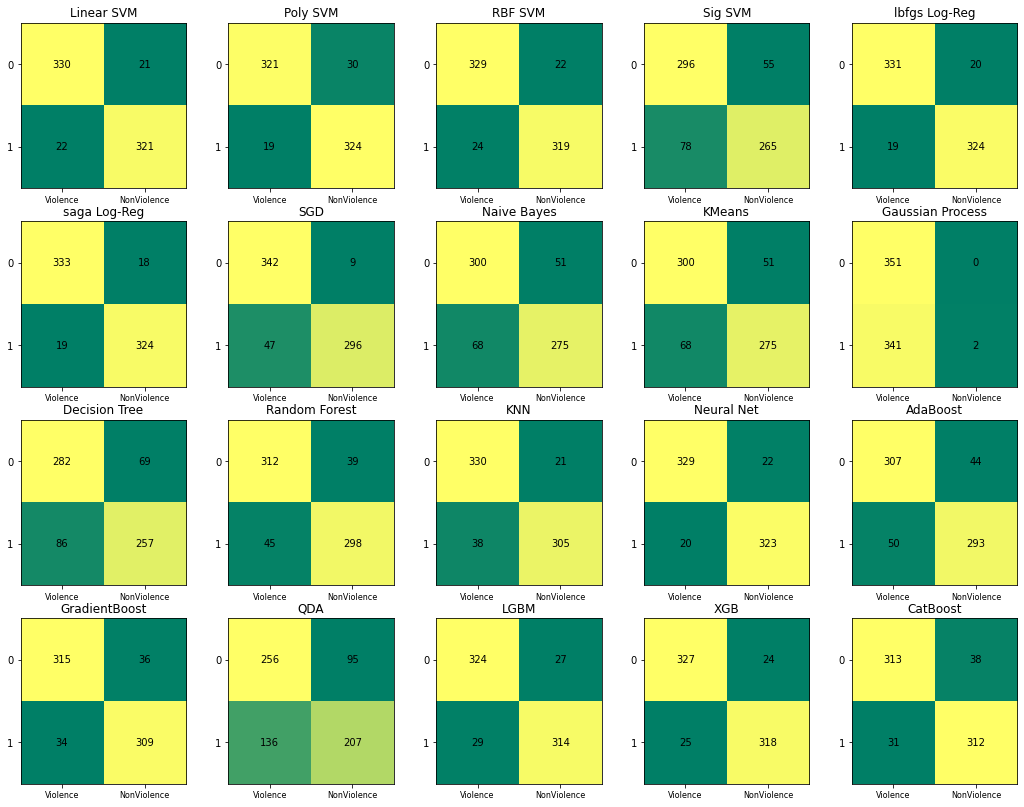

In [22]:
Metrics = runML()

In [23]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time      20.844848
Prediction-time     0.009964
Accuracy           94.668588
Name: saga Log-Reg, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.019865
Prediction-time     0.799835
Accuracy           91.498559
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       5.782317
Prediction-time     0.002626
Accuracy           77.665706
Name: Decision Tree, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
saga Log-Reg,20.844848,0.009964,94.668588
lbfgs Log-Reg,1.995332,0.019992,94.380403
Neural Net,9.194898,0.015031,93.948127
Linear SVM,9.680820,2.479374,93.804035
RBF SVM,13.752248,5.639832,93.371758
Poly SVM,13.169563,3.029689,92.939481
XGB,29.192613,0.032082,92.939481
SGD,1.263867,0.020323,91.930836
LGBM,33.636336,0.013018,91.930836
KNN,0.019865,0.799835,91.498559


## **Classification using Filtered out Features - NO Scaling**

In [24]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(temp_feat_df, labels, test_size=.2, shuffle=True)

In [25]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2774, 2754)
Test data size: (694, 2754)


#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear', max_...
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       350
           1       0.92      0.93      0.93       344

    accuracy                           0.93       694
   macro avg       0.93      0.93      0.93       694
weighted avg       0.93      0.93      0.93       694



Classifier: SVC(kernel='poly', max_it...
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       350
           1       0.95      0.87      0.91       344

    accuracy                           0.91       694
   macro avg       0.92      0.91      0.91       694
weighted avg       0.92      0.91      0.91       694



Classifier: SVC(max_iter=5000)...
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       350
           1       0.9

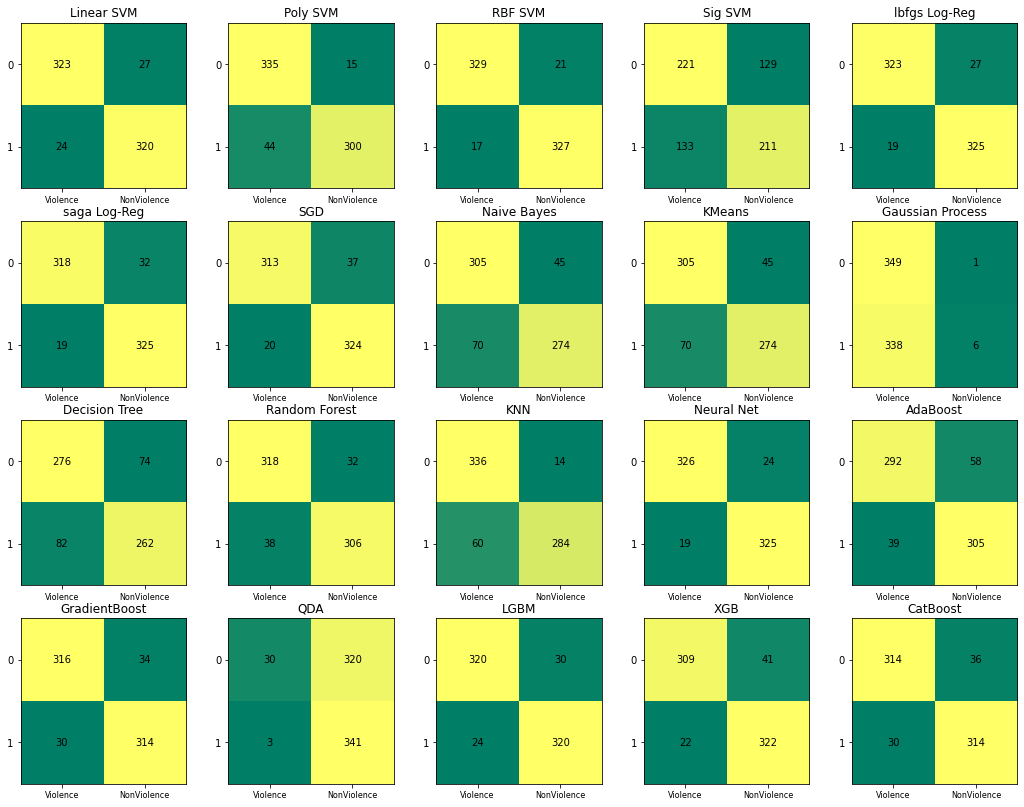

In [28]:
Metrics = runML()

In [29]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       4.337882
Prediction-time     2.236194
Accuracy           94.524496
Name: RBF SVM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.017453
Prediction-time     0.300605
Accuracy           89.337176
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       1.900072
Prediction-time     0.010412
Accuracy           77.521614
Name: Decision Tree, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
RBF SVM,4.337882,2.236194,94.524496
Neural Net,4.264395,0.014997,93.804035
lbfgs Log-Reg,0.698805,0.019996,93.371758
Linear SVM,2.645800,0.554293,92.651297
saga Log-Reg,7.039598,0.011989,92.651297
LGBM,10.650153,0.074869,92.219020
SGD,0.315541,0.018706,91.786744
Poly SVM,3.925224,0.895216,91.498559
XGB,10.454983,0.059330,90.922190
GradientBoost,189.034166,0.019791,90.778098


## **Classification using Filtered out Features - Standard Scaling**

In [30]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(temp_feat_scaled_df, labels, test_size=.2, shuffle=True)

In [31]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2774, 2754)
Test data size: (694, 2754)


#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear', max_...
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       361
           1       0.91      0.91      0.91       333

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694



Classifier: SVC(kernel='poly', max_it...
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       361
           1       0.99      0.58      0.73       333

    accuracy                           0.79       694
   macro avg       0.85      0.79      0.78       694
weighted avg       0.85      0.79      0.78       694



Classifier: SVC(max_iter=5000)...
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       361
           1       0.9

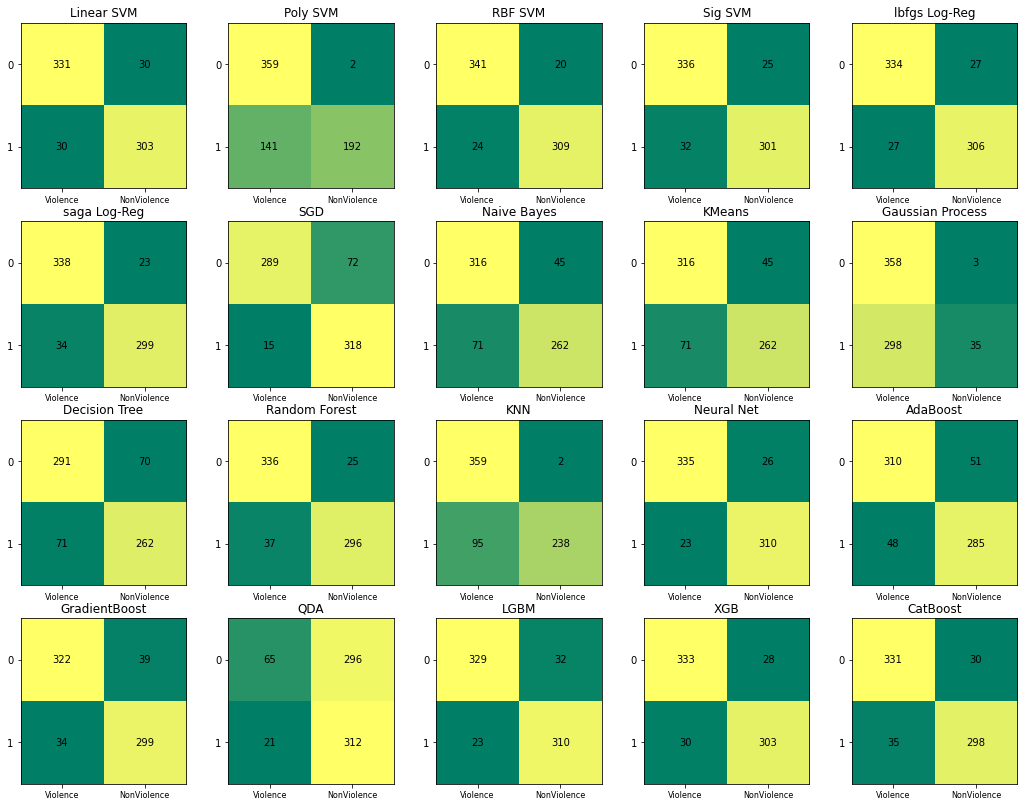

In [32]:
Metrics = runML()

In [33]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       4.783475
Prediction-time     3.162628
Accuracy           93.659942
Name: RBF SVM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.020063
Prediction-time     0.466767
Accuracy           86.023055
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       7.174475
Prediction-time     0.009940
Accuracy           91.786744
Name: saga Log-Reg, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
RBF SVM,4.783475,3.162628,93.659942
Neural Net,2.185034,0.014969,92.939481
lbfgs Log-Reg,0.750062,0.014995,92.219020
LGBM,11.350185,0.085117,92.074928
Sig SVM,3.869369,0.899343,91.786744
saga Log-Reg,7.174475,0.009940,91.786744
XGB,10.693751,0.049911,91.642651
Linear SVM,3.335395,0.654866,91.354467
Random Forest,2.542295,0.037545,91.066282
CatBoost,18.764741,0.169843,90.634006


## **Classification using Filtered out Features - MinMax Scaling**

In [34]:
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(temp_feat_minmax_df, labels, test_size=.2, shuffle=True)

In [35]:
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (2774, 2754)
Test data size: (694, 2754)


#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence

Classification Report for each Classifier:


Classifier: SVC(kernel='linear', max_...
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       341
           1       0.92      0.91      0.91       353

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694



Classifier: SVC(kernel='poly', max_it...
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       341
           1       0.95      0.87      0.91       353

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.92      0.91      0.91       694



Classifier: SVC(max_iter=5000)...
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       341
           1       0.9

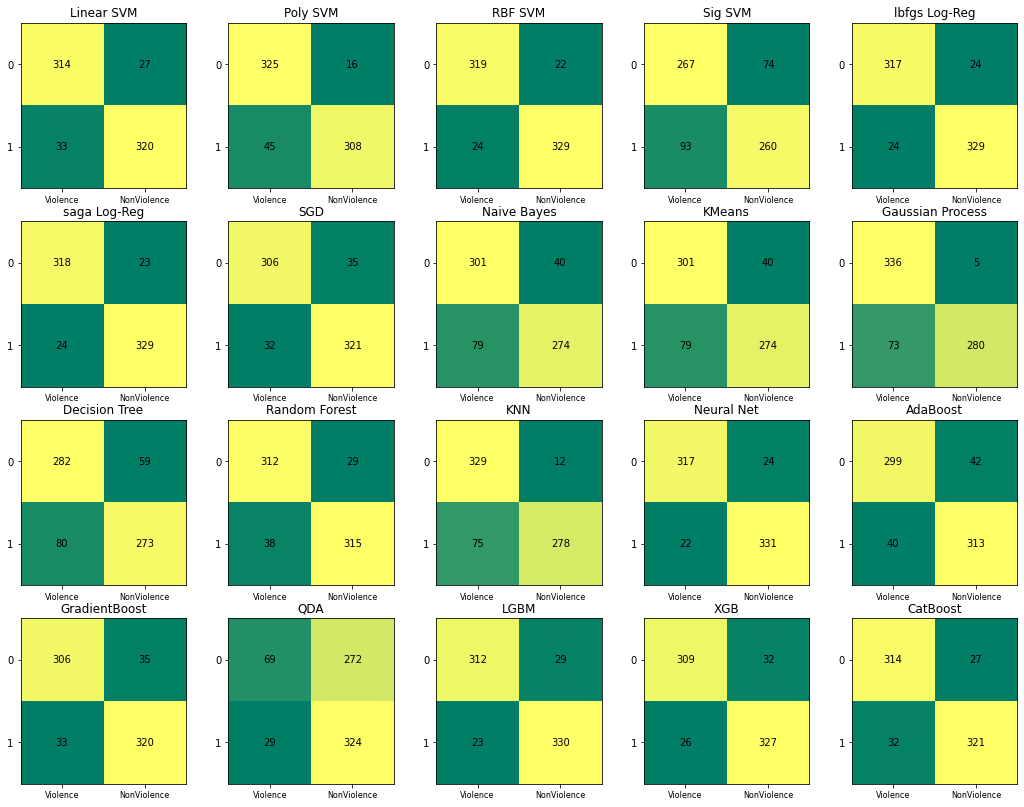

In [36]:
Metrics = runML()

In [37]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       4.282773
Prediction-time     2.217047
Accuracy           93.371758
Name: RBF SVM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.018173
Prediction-time     0.324778
Accuracy           87.463977
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       7.218551
Prediction-time     0.011453
Accuracy           93.227666
Name: saga Log-Reg, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
Neural Net,2.642064,0.020032,93.371758
RBF SVM,4.282773,2.217047,93.371758
saga Log-Reg,7.218551,0.011453,93.227666
lbfgs Log-Reg,0.734892,0.016013,93.083573
LGBM,11.710802,0.079114,92.507205
XGB,11.193686,0.065243,91.642651
CatBoost,18.739917,0.155206,91.498559
Linear SVM,2.977607,0.631124,91.354467
Poly SVM,4.415014,1.030248,91.210375
Random Forest,2.443973,0.028993,90.345821


---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---